In [322]:
#preparation
import csv
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import itertools
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from google.colab import files
uploaded = files.upload()

Saving ML_2_Fellow.csv to ML_2_Fellow (1).csv


In [323]:
#import the file
df=pd.read_csv('ML_2_Fellow.csv',encoding='iso-8859-1')

In [324]:
#cek data description in CSV
print(df.describe())

              Jumlah   Harga_Satuan  Kode_Pelanggan
count  535874.000000  535874.000000   403182.000000
mean        9.587927       4.636533    15287.687868
std       153.292222      97.302232     1714.009551
min    -74215.000000  -11062.060000    12346.000000
25%         1.000000       1.250000    13952.000000
50%         3.000000       2.080000    15152.000000
75%        10.000000       4.130000    16791.000000
max     74215.000000   38970.000000    18287.000000


In [325]:
#cek data head
print(df.head(10))

  Kode_Bayar Kode_Barang  ... Kode_Pelanggan          Negara
0     536365      85123A  ...        17850.0  United Kingdom
1     536365       71053  ...        17850.0  United Kingdom
2     536365      84406B  ...        17850.0  United Kingdom
3     536365      84029G  ...        17850.0  United Kingdom
4     536365      84029E  ...        17850.0  United Kingdom
5     536365       22752  ...        17850.0  United Kingdom
6     536365       21730  ...        17850.0  United Kingdom
7     536366       22633  ...        17850.0  United Kingdom
8     536366       22632  ...        17850.0  United Kingdom
9     536367       84879  ...        13047.0  United Kingdom

[10 rows x 8 columns]


In [326]:
# check type dataFrame
print(pd.DataFrame(df.dtypes))
print(df.shape)

                         0
Kode_Bayar          object
Kode_Barang         object
Barang              object
Jumlah             float64
Tanggal_Transaksi   object
Harga_Satuan       float64
Kode_Pelanggan     float64
Negara              object
(541909, 8)


In [327]:
# change Tanggal_Transaksi to date time format
df['Tanggal_Transaksi'] = pd.to_datetime(df['Tanggal_Transaksi'])

In [328]:
# change Kode_Pelanggan to int
df['Kode_Pelanggan'] = pd.to_numeric(df['Kode_Pelanggan'])

AxesSubplot(0.08,0.125;0.87x0.755)
(541909, 8)


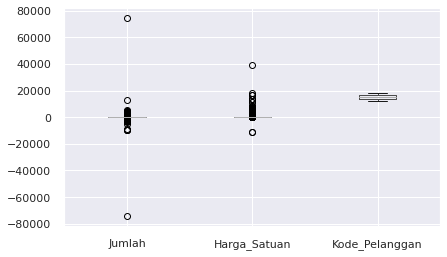

In [329]:
#cek value in data
plt.figure()
print(df.boxplot())
print(df.shape)
#there is a null value and negatif value that resemble cancelation

In [330]:
df.dropna(axis = 0, subset = ['Kode_Pelanggan'], inplace = True)
print(df.shape)

(403182, 8)


In [331]:
#drop duplikat
df.drop_duplicates(inplace = True)
print(df.shape)

(398003, 8)


In [332]:
#check n country
temp = df.groupby(['Kode_Pelanggan', 'Kode_Bayar', 'Negara']).count()
temp = temp.reset_index(drop = False)
countries = temp['Negara'].value_counts()
print(len(countries))
print(countries.head(10))
#most customer from UK

37
United Kingdom    19830
Germany             603
France              458
EIRE                319
Belgium             119
Spain               105
Netherlands         101
Switzerland          71
Portugal             70
Australia            69
Name: Negara, dtype: int64


In [333]:
#cek banyak order barang per negara
temp = df.groupby(['Barang', 'Negara']).count()
temp = temp.reset_index(drop = False)
temp['Negara'].value_counts().head(10)


United Kingdom    3757
EIRE              1967
Germany           1687
France            1530
Spain             1093
Switzerland        945
Netherlands        798
Belgium            780
Portugal           691
Australia          602
Name: Negara, dtype: int64

In [334]:
#Check total order barang
len(df['Kode_Barang'].value_counts())

3603

In [335]:
#Check total kode_bayar
len(df['Kode_Bayar'].value_counts())

22161

In [336]:
#Check banyak cancel
temp = df
temp['Batal'] = df['Kode_Bayar'].apply(lambda x:int('C' in x))
print(temp.sort_values(by='Batal', ascending=False).head())

       Kode_Bayar Kode_Barang  ...          Negara  Batal
217767    C555935       23049  ...          France      1
70659     C542092       22663  ...  United Kingdom      1
70657     C542092       20723  ...  United Kingdom      1
70656     C542092       21931  ...  United Kingdom      1
70655     C542092       20725  ...  United Kingdom      1

[5 rows x 9 columns]


In [337]:
#cek banyak order barang batal
temp = temp.groupby(['Negara', 'Batal']).count()
temp = temp.reset_index(drop = False)
temp['Negara'].value_counts().head(10)

Saudi Arabia      2
Italy             2
Austria           2
Israel            2
Sweden            2
Australia         2
Poland            2
Czech Republic    2
EIRE              2
USA               2
Name: Negara, dtype: int64

In [338]:
df1 = df.copy(deep = True)
df1['nBatal'] = 0

df_hapus = []

for index, col in  df.iterrows():
    if (col['Jumlah'] > 0) or col['Barang'] == 'Discount': continue        
    df_test = df[(df['Kode_Pelanggan'] == col['Kode_Pelanggan']) &
                         (df['Kode_Barang']  == col['Kode_Barang']) & 
                         (df['Tanggal_Transaksi'] < col['Tanggal_Transaksi']) & 
                         (df['Jumlah']   > 0)].copy()
    if (df_test.shape[0] == 0): 
        df_hapus.append(index)
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df1.loc[index_order, 'nBatal'] = -col['Jumlah']
        df_hapus.append(index)        
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Jumlah'] < -col['Jumlah']: continue
            df1.loc[ind, 'nBatal'] = -col['Jumlah']
            df_hapus.append(index) 
            break   


In [339]:
#banyak n dihapus
print(len(df_hapus))

8682


In [340]:
#Check banyak cancel
temp = df1
print(temp.sort_values(by='nBatal', ascending=False).head())

       Kode_Bayar Kode_Barang  ... Batal  nBatal
61619      541431       23166  ...     0   74215
52711      540815       21108  ...     0    3114
52710      540815       21175  ...     0    2000
52709      540815      85123A  ...     0    1930
223446     556484       22920  ...     0    1515

[5 rows x 10 columns]


In [341]:
#check C cancel
print(df.sort_values(by='Jumlah', ascending=True).head())

       Kode_Bayar Kode_Barang  ...          Negara  Batal
61624     C541433       23166  ...  United Kingdom      1
4287      C536757       84347  ...  United Kingdom      1
160145    C550456       21108  ...  United Kingdom      1
160144    C550456       21175  ...  United Kingdom      1
160143    C550456      85123A  ...  United Kingdom      1

[5 rows x 9 columns]


In [342]:
#filter nBatal with only 0
temp = temp[temp['nBatal'] == 0]

In [343]:
#filter negatif transaction
df_clean = temp[temp['Jumlah'] >= 0]
df_clean.sort_values(by='Batal', ascending=True).head()
#free from negatif transaction and cancelation
del(df_clean["Batal"])
del(df_clean["nBatal"])

In [344]:
print(df_clean.head())

  Kode_Bayar Kode_Barang  ... Kode_Pelanggan          Negara
0     536365      85123A  ...        17850.0  United Kingdom
1     536365       71053  ...        17850.0  United Kingdom
2     536365      84406B  ...        17850.0  United Kingdom
3     536365      84029G  ...        17850.0  United Kingdom
4     536365      84029E  ...        17850.0  United Kingdom

[5 rows x 8 columns]


In [345]:
# get the goods with highest order
sum = df_clean.groupby(['Barang']).sum()
print(sum.sort_values(by='Jumlah', ascending=False).head(10))

                                     Jumlah  Harga_Satuan  Kode_Pelanggan
Barang                                                                   
WORLD WAR 2 GLIDERS ASSTD DESIGNS   52879.0        136.74       7141480.0
JUMBO BAG RED RETROSPOT             43423.0       3187.39      24162344.0
ASSORTED COLOUR BIRD ORNAMENT       35032.0       2331.31      21123368.0
WHITE HANGING HEART T-LIGHT HOLDER  33287.0       5727.07      30803197.0
PACK OF 72 RETROSPOT CAKE CASES     33286.0        570.22      15703626.0
POPCORN HOLDER                      27949.0        529.04       9626225.0
RABBIT NIGHT LIGHT                  26619.0       1629.13      12046671.0
MINI PAINT SET VINTAGE              25752.0        208.17       4670379.0
PACK OF 12 LONDON TISSUES           25293.0        127.04       6123285.0
PACK OF 60 PINK PAISLEY CAKE CASES  24086.0        370.01      10300366.0


In [346]:
# get the goods with Least order
sum = df_clean.groupby(['Barang']).sum()
least = sum[sum['Jumlah'] == 1.0]
print(least.head())
print("nLeast : " + str(len(least)))

                                    Jumlah  Harga_Satuan  Kode_Pelanggan
Barang                                                                  
 I LOVE LONDON MINI RUCKSACK           1.0          4.15         14646.0
AMBER BERTIE GLASS BEAD BAG CHARM      1.0          2.10         17550.0
AMBER GLASS/SHELL/PEARL NECKLACE       1.0          8.95         13709.0
BAROQUE BUTTERFLY EARRINGS CRYSTAL     1.0          3.75         17571.0
BLACK DROP EARRINGS W LONG BEADS       1.0          2.95         14570.0
nLeast : 62


In [347]:
barangUnique = pd.DataFrame(df_clean['Barang'].unique()).rename(columns = {0:'Barang'})
print(barangUnique.sort_values(by='Barang', ascending=False).head(10))
print(len(barangUnique))

                                Barang
2912  ZINC WIRE SWEETHEART LETTER TRAY
2960       ZINC WIRE KITCHEN ORGANISER
94    ZINC WILLIE WINKIE  CANDLE STICK
2391    ZINC TOP  2 DOOR WOODEN SHELF 
2901   ZINC T-LIGHT HOLDER STARS SMALL
3084   ZINC T-LIGHT HOLDER STARS LARGE
2909    ZINC T-LIGHT HOLDER STAR LARGE
2880  ZINC SWEETHEART WIRE LETTER RACK
2964         ZINC SWEETHEART SOAP DISH
3089         ZINC STAR T-LIGHT HOLDER 
3755


In [348]:
print(df_clean.head())

  Kode_Bayar Kode_Barang  ... Kode_Pelanggan          Negara
0     536365      85123A  ...        17850.0  United Kingdom
1     536365       71053  ...        17850.0  United Kingdom
2     536365      84406B  ...        17850.0  United Kingdom
3     536365      84029G  ...        17850.0  United Kingdom
4     536365      84029E  ...        17850.0  United Kingdom

[5 rows x 8 columns]


In [358]:
temp1=df_clean.copy(deep = True)

In [359]:
print(temp1.head())

  Kode_Bayar Kode_Barang  ... Kode_Pelanggan          Negara
0     536365      85123A  ...        17850.0  United Kingdom
1     536365       71053  ...        17850.0  United Kingdom
2     536365      84406B  ...        17850.0  United Kingdom
3     536365      84029G  ...        17850.0  United Kingdom
4     536365      84029E  ...        17850.0  United Kingdom

[5 rows x 8 columns]


In [360]:
df_cleaned = (df_clean.groupby(['Kode_Pelanggan','Negara'],as_index=False).agg({'Kode_Bayar':'nunique', 'Kode_Barang':'nunique','Harga_Satuan':'mean','Jumlah':'sum'}))
df_cleaned
df_cleaned.reset_index()
df_cleaned['rerata']=df_cleaned['Jumlah']/df_cleaned['Kode_Bayar']
df_cleaned = df_cleaned[['Kode_Bayar','Harga_Satuan','rerata']]

In [361]:
#find the outlier and remove
index = 0
while index<=len(df_cleaned)-1:
    q1, q3 = np.percentile(df_cleaned['rerata'], [25, 75])
    iqr = q3 - q1
    lb = q1 - (iqr *1.5 )
    ub = q3 + (iqr *1.5)
    
    if df_cleaned.loc[index,'rerata']> ub:
        df_cleaned.loc[index,'outlier']=1
    elif df_cleaned.loc[index,'rerata']< lb:
        df_cleaned.loc[index,'outlier']=1
    else:
        df_cleaned.loc[index,'outlier']=0
    index += 1


AxesSubplot(0.08,0.125;0.87x0.755)


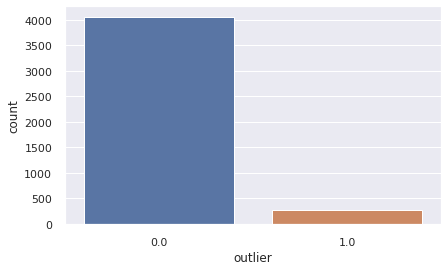

In [362]:
print(sns.countplot(x="outlier", data=df_cleaned))

In [363]:
#remove the outlier
df_cleaned = df_cleaned[df_cleaned['outlier']==0]
df_cleaned = df_cleaned.drop(columns=['outlier'])

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a31986b50>,
                 k=None, metric=None, model=None, timings=True)


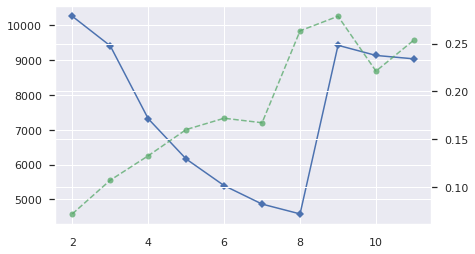

In [364]:
#Elbow Method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
print(visualizer.fit(df_cleaned))

In [365]:
#Clustering
kmeans = KMeans(5)
kmeans.fit(df_cleaned)
identified_clusters = kmeans.fit_predict(df_cleaned)
data_with_clusters = df_cleaned.copy()
data_with_clusters['Cluster'] = identified_clusters
print("cluster center:")
print(kmeans.cluster_centers_)
print(identified_clusters)

cluster center:
[[4.78760046e+00 2.77152114e+00 2.60256897e+02]
 [3.32897454e+00 5.26910039e+00 6.67451991e+01]
 [4.34469697e+00 3.11175268e+00 1.53838390e+02]
 [1.00000000e+00 2.03310000e+03 1.00000000e+00]
 [4.90338164e+00 2.50404002e+00 3.97875147e+02]]
[4 2 1 ... 1 1 1]


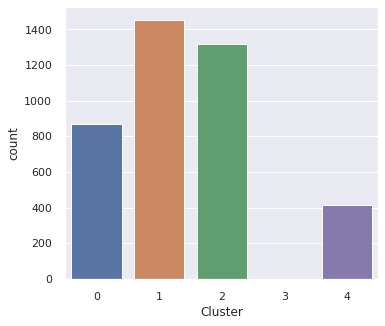

<Figure size 432x288 with 0 Axes>

In [366]:
#plot data with clusters
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(x="Cluster", data=data_with_clusters)
data_with_clusters.groupby(['Cluster']).count()
fig = plt.figure()